In [1]:
import pandas as pd
import supy as sp
import matplotlib.pyplot as plt
from functions.night import *
from functions.dict_legend import *
from scipy.stats import pearsonr, linregress
from pathlib import Path
#from sklearn.linear_model import LinearRegression
p_dir_input = Path('../data/')
sp.show_version()

SuPy version: 2024.3.14.dev0
-------------


In [2]:
# OHM. Sampledata Q* modelled with L↓ modelled using air temperature and relative humidity supplied in meteorological forcing file [Loridan et al., 2011]. Zenith angle not accounted for in albedo calculation.d
p_dir_ohm = p_dir_input / "sample_data"
p_runcontrol_ohm = p_dir_ohm / "RunControl.nml"
df_state_init_ohm = sp.init_supy(p_runcontrol_ohm)

grid = df_state_init_ohm.index[0]
df_forcing = sp.load_forcing_grid(p_runcontrol_ohm, grid)

# Sampledata SpartacusECH, standard values in GridLayout
p_dir_ehc_ss = p_dir_input / "sample_data2"
p_runcontrol_ehc_ss = p_dir_ehc_ss / "RunControl.nml"
df_state_init_ehc_ss = sp.init_supy(p_runcontrol_ehc_ss)

2024-04-09 09:00:08,634 - SuPy - INFO - All cache cleared.
2024-04-09 09:00:10,082 - SuPy - INFO - All cache cleared.
2024-04-09 09:00:19,027 - SuPy - INFO - All cache cleared.


In [3]:
# check input
df_state_init_ehc_ss.dz_wall
#df_state_init_ehc_ss.dz_roof
#df_state_init_ehc_ss.dz_surf
#df_state_init_ehc_ss.storageheatmethod
#df_state_init_ehc_ss.netradiationmethod
#df_state_init_ehc_ss.sfr_surf
#df_state_init_ehc_ss.tin_wall
#df_state_init_ehc_ss.tin_roof
df_state_init_ehc_ss.alb_wall
df_state_init_ehc_ss.alb_roof

ind_dim,"(0,)","(1,)","(2,)"
grid,,,
1,0.5,0.5,0.2


In [4]:
#Tings new settings

# modify layer thickness
df_state_init_ehc_ss.dz_wall = 0.07
df_state_init_ehc_ss.dz_roof = 0.07
df_state_init_ehc_ss.loc[:, 'dz_surf'] = np.repeat(
    [
        [0.07, 0.2, 0.5, 1.0, 2.0],
    ],
    7,
    axis=0,
).flatten()

# modify albedo of building facets
df_state_init_ehc_ss.alb_wall = 0.2
df_state_init_ehc_ss.alb_roof = 0.2

# modify inner surface temperatures
df_state_init_ehc_ss.tin_wall = 18.0
df_state_init_ehc_ss.tin_roof = 18.0

In [5]:
# Metdata
grid = df_state_init_ohm.index[0]
s = '2012 07 1'
# s2 = '2012 07 10'
e = '2012 07 31'

# # warm week 2012  to reduce time for test setup
df_forcing_sel=df_forcing.loc[s: e].iloc[1:]

In [6]:
df_output_ohm, df_state_final_ohm = sp.run_supy(df_forcing_sel, df_state_init_ohm)
df_output_ehc_ss, df_state_final_ehc_ss = sp.run_supy(df_forcing_sel, df_state_init_ehc_ss)

2024-04-09 09:00:20,383 - SuPy - INFO - ====================
2024-04-09 09:00:20,385 - SuPy - INFO - Simulation period:
2024-04-09 09:00:20,385 - SuPy - INFO -   Start: 2012-07-01 00:05:00
2024-04-09 09:00:20,386 - SuPy - INFO -   End: 2012-07-31 23:55:00
2024-04-09 09:00:20,387 - SuPy - INFO - 
2024-04-09 09:00:20,388 - SuPy - INFO - No. of grids: 1
2024-04-09 09:00:20,389 - SuPy - INFO - SuPy is running in serial mode
2024-04-09 09:00:26,013 - SuPy - INFO - Execution time: 5.6 s
2024-04-09 09:00:26,014 - SuPy - INFO - ====================

2024-04-09 09:00:26,016 - SuPy - INFO - ====================
2024-04-09 09:00:26,018 - SuPy - INFO - Simulation period:
2024-04-09 09:00:26,019 - SuPy - INFO -   Start: 2012-07-01 00:05:00
2024-04-09 09:00:26,021 - SuPy - INFO -   End: 2012-07-31 23:55:00
2024-04-09 09:00:26,023 - SuPy - INFO - 
2024-04-09 09:00:26,025 - SuPy - INFO - No. of grids: 1
2024-04-09 09:00:26,026 - SuPy - INFO - SuPy is running in serial mode
2024-04-09 09:07:14,286 - Su

In [7]:
df_output_comp = (
    pd.concat(
        [df_output_ohm, df_output_ehc_ss], axis=1, keys=["OHM", "EHC"], names=["cfg"]
    )
    .loc[1]
    .swaplevel("cfg", "group", axis=1)
    .swaplevel("cfg", "var", axis=1)
    .sort_index(axis=1)
    .rename(columns={"ESTMExt": "EHC"})
)

In [8]:
ser_qs_bldg = (
    df_output_comp.EHC.filter(like="QS_")
    .filter(like="EHC")
    .filter(regex="Bldgs|Paved")
    .dropna(axis=1)
    .droplevel("cfg", axis=1)
)
ser_qs_bldg

var,QS_Bldgs,QS_Paved
datetime,,
2012-07-01 00:05:00,255.526604,122.019049
2012-07-01 00:10:00,550.164235,117.670490
2012-07-01 00:15:00,183.811274,127.184296
2012-07-01 00:20:00,528.239297,109.789968
2012-07-01 00:25:00,106.103371,118.118431
...,...,...
2012-07-31 23:35:00,-85.615987,-34.613488
2012-07-31 23:40:00,-85.603722,-34.636920
2012-07-31 23:45:00,-85.611568,-34.665509


In [30]:
df_state_init_ehc_ss.loc[:, "dz_surf"]

ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)",...,"(5, 0)","(5, 1)","(5, 2)","(5, 3)","(5, 4)","(6, 0)","(6, 1)","(6, 2)","(6, 3)","(6, 4)"
grid,,,,,,,,,,,,,,,,,,,,,
1,0.07,0.2,0.5,1.0,2.0,0.07,0.2,0.5,1.0,2.0,...,0.07,0.2,0.5,1.0,2.0,0.07,0.2,0.5,1.0,2.0


In [39]:
#Fredriks settings according to Lindberg et al. 2020 (URBANFLUXES)

# Setting correct ground layer parameters (807 from ESTM coefficients, used in Lindberg et al. 2020)
# EHC as heat storage scheme
df_state_ehc_ss_FL = df_state_init_ehc_ss.copy()

# modify the depth of the vertical layers
ar_depth = np.repeat(np.array([[0.06, 0.3, 0.5, 0.7, 1.5]]), 7, axis=0).flatten() #changed first layer to 0.06 from 0.05 due to instability. Test last layer thicker
df_state_ehc_ss_FL.loc[:, "dz_surf"] = ar_depth

# modify the heat capacity of the vertical layers
ar_cp = np.repeat(np.array([[1.86, 1.86, 1.2, 1.2, 1.2]])*1e6, 7, axis=0).flatten()
df_state_ehc_ss_FL.loc[:, "cp_surf"] = ar_cp

# modify the thermal conductivity of the vertical layers
ar_k = np.repeat(np.array([[0.759, 0.759, 0.63, 0.63, 0.63]]) , 7, axis=0).flatten()
df_state_ehc_ss_FL.loc[:, "k_surf"] = ar_k


# modify the depth of the wall layers
ar_depth = np.repeat(np.array([[0.087, 0.0497, 0.0497, 0.001, 0.001]]), 3, axis=0).flatten()
df_state_ehc_ss_FL.loc[:, "dz_wall"] = ar_depth

# modify the heat capacity of the wall layers
ar_cp = np.repeat(np.array([[1.047, 1.5, 1.5, 1.2, 1.2]])*1e6, 3, axis=0).flatten()
df_state_ehc_ss_FL.loc[:, "cp_wall"] = ar_cp

# modify the thermal conductivity of the wall layers
ar_k = np.repeat(np.array([[0.761, 0.93, 0.93, 0.63, 0.63]]) , 3, axis=0).flatten()
df_state_ehc_ss_FL.loc[:, "k_wall"] = ar_k



# modify albedo of building facets (from Ting) Too low?
df_state_ehc_ss_FL.alb_wall = 0.2 # ting 0.2
df_state_ehc_ss_FL.alb_roof = 0.2 # ting 0.2

# modify inner surface temperatures (from Ting) Too low?
df_state_ehc_ss_FL.tin_wall = 18.0
df_state_ehc_ss_FL.tin_roof = 18.0

df_output_ehc_ss_FL, df_state_final_ehc_ss_FL = sp.run_supy(df_forcing_sel, df_state_ehc_ss_FL)

2024-04-09 11:12:10,363 - SuPy - INFO - ====================
2024-04-09 11:12:10,364 - SuPy - INFO - Simulation period:
2024-04-09 11:12:10,366 - SuPy - INFO -   Start: 2012-07-01 00:05:00
2024-04-09 11:12:10,368 - SuPy - INFO -   End: 2012-07-31 23:55:00
2024-04-09 11:12:10,370 - SuPy - INFO - 


2024-04-09 11:12:10,372 - SuPy - INFO - No. of grids: 1
2024-04-09 11:12:10,375 - SuPy - INFO - SuPy is running in serial mode
2024-04-09 11:20:13,464 - SuPy - INFO - Execution time: 483.1 s
2024-04-09 11:20:13,465 - SuPy - INFO - ====================



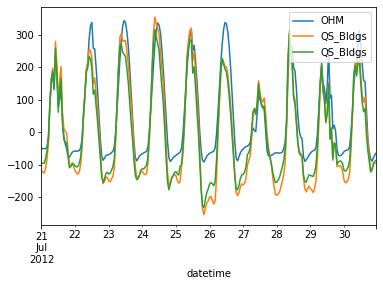

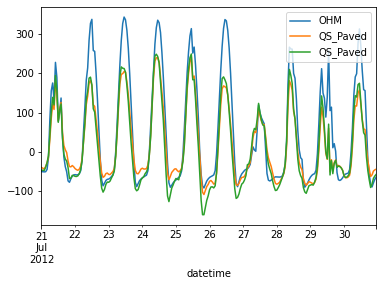

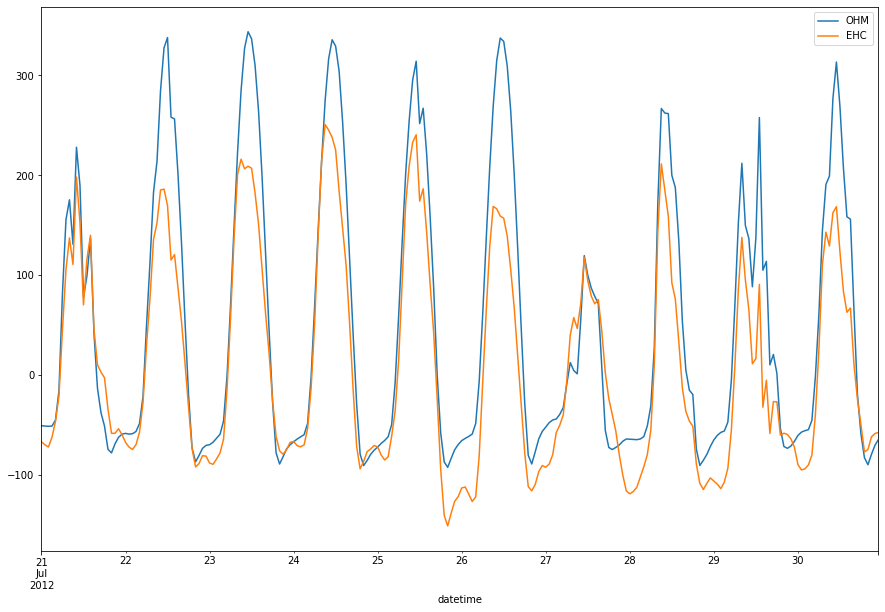

In [40]:
df_output_comp2 = (
    pd.concat(
        [df_output_ohm, df_output_ehc_ss, df_output_ehc_ss_FL], axis=1, keys=["OHM", "EHC", "EHCFL"], names=["cfg"]
    )
    .loc[1]
    .swaplevel("cfg", "group", axis=1)
    .swaplevel("cfg", "var", axis=1)
    .sort_index(axis=1)
    .rename(columns={"ESTMExt": "EHC"})
    )

ser_qs_bldg2 = (
    df_output_comp2.EHC.filter(like="QS_")
    .filter(like="EHC")
    .filter(regex="Bldgs|Paved")
    .dropna(axis=1)
    .droplevel("cfg", axis=1)
)

df_comp_qs2 = pd.concat([df_output_comp2["SUEWS"].QS, ser_qs_bldg2], axis=1)
_=df_comp_qs2.resample("1h").mean().loc['2012-7-21':'2012-7-30',['OHM','QS_Bldgs']].plot()
_=df_comp_qs2.resample("1h").mean().loc['2012-7-21':'2012-7-30',['OHM','QS_Paved']].plot()
ax = (
    df_comp_qs2.resample("1h")
    .mean()
    .loc["2012-7-21":"2012-7-30", ["OHM", "EHC"]]
    .iloc[:, :2]
    .plot(figsize=(15, 10))
)

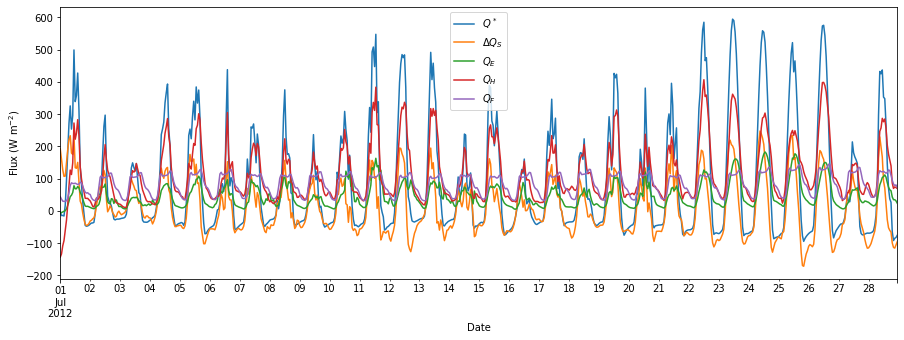

In [43]:
#Plot output for test run
df_output_test = df_output_ehc_ss_FL['SUEWS']
# a dict for better display variable names
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}
ax_output = df_output_test\
    .loc[grid]\
    .resample("1h").mean()\
    .loc['2012 7 01':'2012 7 28',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(figsize=(15, 5))
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()